# PK/PD AL Blood Volume and Hill Equation analyses
# Date: 07/31/2025

## 1. Studying how variable BMI affects the ER curve after implementing allometric scaling on dose/concentration
<br>

In [10]:
import datetime 

from math import *
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
from multiprocessing import Pool, cpu_count

import numpy as np

import os

import pandas as pd
import pickle

import random

from scipy.optimize import curve_fit
import subprocess
import sys

import time
from tqdm import tqdm  # For progress bar

### a. Default PD model
#### ```patient_blood_volume = weight * 70 * 1000```

#### Instantaeneous hourly killing rate ```a```

$$
(\frac{-1}{24}) \times ln({1.0} - \frac{P_{max}\times{concentration}^n}{{concentration}^n + EC_{50}^n})
$$

#### Killing fraction:
$$
\frac{P_{max}\times concentration^n}{concentration^n + EC_{50}^n}
$$

#### Hourly killing rate:
$$
(\frac{-1}{24}) \times ln({1.0} - killing fraction)
$$


---

#### Net hourly growth rate:

$g = 0.048$

$ net\,hourly\,growth\,rate = g - \,hourly \,killing \,rate$


----

#### Calculating BV using the Lemmens-Bernstein-Brodsky Equation

$$
BV = \frac{70 \times patient~weight}{\sqrt{\frac{BMI}{22}}}
$$

#### Using BMI Range: 18.5 to < 25


----

<br>

#### Calculating concentration using allometric scaling

$$
concentration~= \frac{dose~\times~weight^{0.75}}{weight~\times~\frac{70}{\sqrt\frac{18.5}{22}}}
$$

---

<br>

In [2]:
def generate_recommended_dosing_schedule(weight):
    if weight < 15.0:
        num_tablets_per_dose = 0.50
    elif weight < 25.0:
        num_tablets_per_dose = 1.0
    elif weight < 35.0:
        num_tablets_per_dose = 1.50
    else:
        num_tablets_per_dose = 2.0
    total_mg_dose_per_occassion = num_tablets_per_dose * 40.0;
    return total_mg_dose_per_occassion

In [3]:
def sigmoid_function(concentration, pmax, ec50, n):
    return (pmax * (concentration ** n)) / ((concentration ** n) + (ec50 ** n))

In [17]:
random.choice(patient_BMI).round(2)

np.float64(21.7)

### 1. Using WHO dosing regimen and random BMI between weights

In [19]:
# Generating total dose for each weight over 3 days with twice daily dosing
weight_values = list(range(5, 101, 5))  # Re-defining weight values for clarity
total_dose_mg = []

for weight in weight_values:
    total_mg_dose = generate_recommended_dosing_schedule(weight) * 6  # Assuming 3 days of treatment
    total_dose_mg.append(total_mg_dose)
# for i in range(len(weight_values)):
#     print(f"Total dose for weight {weight_values[i]} kg: {total_dose_mg[i]} mg")

upper_limit_mg = total_dose_mg
lower_limit_mg = [0] * len(weight_values)

lower_limit_concentration = []
upper_limit_concentration = []

patient_BMI = np.arange(18.5, 25, 0.1)  

for i in range(len(weight_values)):
    BMI_to_use = random.choice(patient_BMI).round(2)
    print(f"Using BMI: {BMI_to_use} for weight {weight_values[i]}")
    lower_limit_concentration.append(lower_limit_mg[i] / ((weight_values[i] ** 0.25)* (70/np.sqrt((BMI_to_use)/22))))  
    print(f"Lower limit concentration for weight {weight_values[i]} kg: {lower_limit_concentration[i]} mg/mL, with ")
    upper_limit_concentration.append(upper_limit_mg[i] / ((weight_values[i] ** 0.25)* (70/np.sqrt((BMI_to_use)/22))))
    print(f"Upper limit concentration for weight {weight_values[i]} kg: {upper_limit_concentration[i]} mg/mL")

artemether_concentrations_mg_ml_final = []
for i in range(len(weight_values)):
    temp_conc = np.linspace(lower_limit_concentration[i], upper_limit_concentration[i], 1000)
    artemether_concentrations_mg_ml_final.append(temp_conc)

#Convert artemether_concentrations_ng_ml_final to artemether_concentrations_mg_ml_final
artemether_concentrations_ng_ml_final = []
for i in range(len(artemether_concentrations_mg_ml_final)):
    temp_conc = artemether_concentrations_mg_ml_final[i] * (10**6)  # Convert mg/mL to ng/mL
    artemether_concentrations_ng_ml_final.append(temp_conc)

pmax = 0.99997
ec50_dose_ng = 1*(10**6)  # Convert ng/mL to ng/mg
ec50_dose_mg = 1  
n = 20
ec50_concentrations_ng = [ec50_dose_ng for weight in weight_values] # Assuming ec50 is already a concentration
ec50_concentrations_mg = [ec50_dose_mg for weight in weight_values]  # Convert ng/mL to mg/mL

print("EC50 Concentrations (ng/mL):", ec50_concentrations_ng)
print("EC50 Concentrations (mg/mL):", ec50_concentrations_mg)

Using BMI: 18.6 for weight 5
Lower limit concentration for weight 5 kg: 0.0 mg/mL, with 
Upper limit concentration for weight 5 kg: 1.0541097652545919 mg/mL
Using BMI: 19.8 for weight 10
Lower limit concentration for weight 10 kg: 0.0 mg/mL, with 
Upper limit concentration for weight 10 kg: 0.9145436965914461 mg/mL
Using BMI: 19.1 for weight 15
Lower limit concentration for weight 15 kg: 0.0 mg/mL, with 
Upper limit concentration for weight 15 kg: 1.6232885679979765 mg/mL
Using BMI: 22.6 for weight 20
Lower limit concentration for weight 20 kg: 0.0 mg/mL, with 
Upper limit concentration for weight 20 kg: 1.6432308582250772 mg/mL
Using BMI: 24.6 for weight 25
Lower limit concentration for weight 25 kg: 0.0 mg/mL, with 
Upper limit concentration for weight 25 kg: 2.432067765875523 mg/mL
Using BMI: 23.9 for weight 30
Lower limit concentration for weight 30 kg: 0.0 mg/mL, with 
Upper limit concentration for weight 30 kg: 2.290402226208188 mg/mL
Using BMI: 23.0 for weight 35
Lower limit con

In [20]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(weight_values)):
    print(f"Total Concentration range for weight {weight_values[i]} kg is: {artemether_concentrations_ng_ml_final[i][0]} ng/mL to {artemether_concentrations_ng_ml_final[i][-1]} ng/mL")

Total Concentration range for weight 5 kg is: 0.0 ng/mL to 1054109.7652545918 ng/mL
Total Concentration range for weight 10 kg is: 0.0 ng/mL to 914543.6965914461 ng/mL
Total Concentration range for weight 15 kg is: 0.0 ng/mL to 1623288.5679979764 ng/mL
Total Concentration range for weight 20 kg is: 0.0 ng/mL to 1643230.8582250772 ng/mL
Total Concentration range for weight 25 kg is: 0.0 ng/mL to 2432067.765875523 ng/mL
Total Concentration range for weight 30 kg is: 0.0 ng/mL to 2290402.226208188 ng/mL
Total Concentration range for weight 35 kg is: 0.0 ng/mL to 2882562.7083297507 ng/mL
Total Concentration range for weight 40 kg is: 0.0 ng/mL to 2500361.0405998533 ng/mL
Total Concentration range for weight 45 kg is: 0.0 ng/mL to 2592805.600782426 ng/mL
Total Concentration range for weight 50 kg is: 0.0 ng/mL to 2537342.872223205 ng/mL
Total Concentration range for weight 55 kg is: 0.0 ng/mL to 2596863.4464910505 ng/mL
Total Concentration range for weight 60 kg is: 0.0 ng/mL to 2573354.780

In [21]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(weight_values)):
    print(f"Total Concentration range for weight {weight_values[i]} kg is: {artemether_concentrations_mg_ml_final[i][0]} mg/mL to {artemether_concentrations_mg_ml_final[i][-1]} mg/mL")

Total Concentration range for weight 5 kg is: 0.0 mg/mL to 1.0541097652545919 mg/mL
Total Concentration range for weight 10 kg is: 0.0 mg/mL to 0.9145436965914461 mg/mL
Total Concentration range for weight 15 kg is: 0.0 mg/mL to 1.6232885679979765 mg/mL
Total Concentration range for weight 20 kg is: 0.0 mg/mL to 1.6432308582250772 mg/mL
Total Concentration range for weight 25 kg is: 0.0 mg/mL to 2.432067765875523 mg/mL
Total Concentration range for weight 30 kg is: 0.0 mg/mL to 2.290402226208188 mg/mL
Total Concentration range for weight 35 kg is: 0.0 mg/mL to 2.8825627083297505 mg/mL
Total Concentration range for weight 40 kg is: 0.0 mg/mL to 2.500361040599853 mg/mL
Total Concentration range for weight 45 kg is: 0.0 mg/mL to 2.5928056007824263 mg/mL
Total Concentration range for weight 50 kg is: 0.0 mg/mL to 2.537342872223205 mg/mL
Total Concentration range for weight 55 kg is: 0.0 mg/mL to 2.5968634464910507 mg/mL
Total Concentration range for weight 60 kg is: 0.0 mg/mL to 2.57335478

Text(0.5, 1.0, 'Artemether Concentration Distribution by Weight')

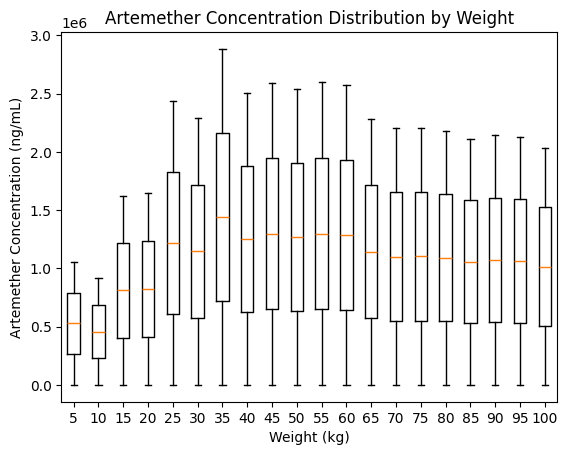

In [22]:
plt.boxplot(artemether_concentrations_ng_ml_final, tick_labels=weight_values)
plt.xlabel('Weight (kg)')
plt.ylabel('Artemether Concentration (ng/mL)')
plt.title('Artemether Concentration Distribution by Weight')

Text(0.5, 1.0, 'Artemether Concentration Distribution by Weight')

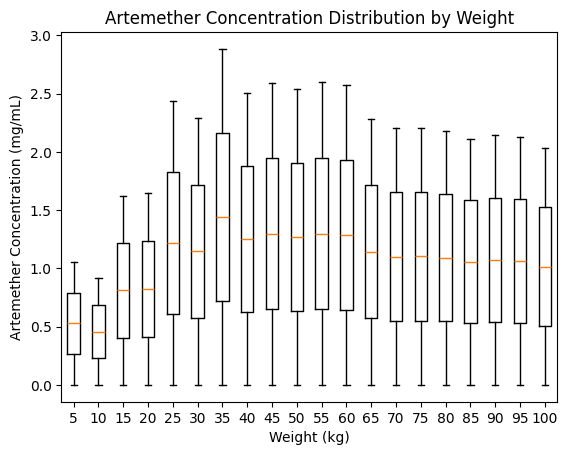

In [23]:
plt.boxplot(artemether_concentrations_mg_ml_final, tick_labels=weight_values)
plt.xlabel('Weight (kg)')
plt.ylabel('Artemether Concentration (mg/mL)')
plt.title('Artemether Concentration Distribution by Weight')

In [24]:
kill_fraction = []
killing_rates = []

for i in range(0, len(artemether_concentrations_ng_ml_final)):
    temp_kill_fraction = []
    temp_killing_rates = []
    for concentration in artemether_concentrations_ng_ml_final[i]:
        temp_kill_fraction.append(sigmoid_function(concentration, pmax, ec50_concentrations_ng[i], n))
        temp_killing_rates.append((-1/24) * np.log(1.0 - temp_kill_fraction[-1]))
    kill_fraction.append(temp_kill_fraction)
    killing_rates.append(temp_killing_rates)

growth_rate = 0.048 
effect = [] 

for i in range(len(killing_rates)):
    effect.append(growth_rate - np.array(killing_rates[i]))

kill_percent = []
for i in range(len(kill_fraction)):
    temp_kill_percent = []
    for j in range(len(kill_fraction[i])):
        temp_kill_percent.append(kill_fraction[i][j] * 100)
    kill_percent.append(temp_kill_percent)

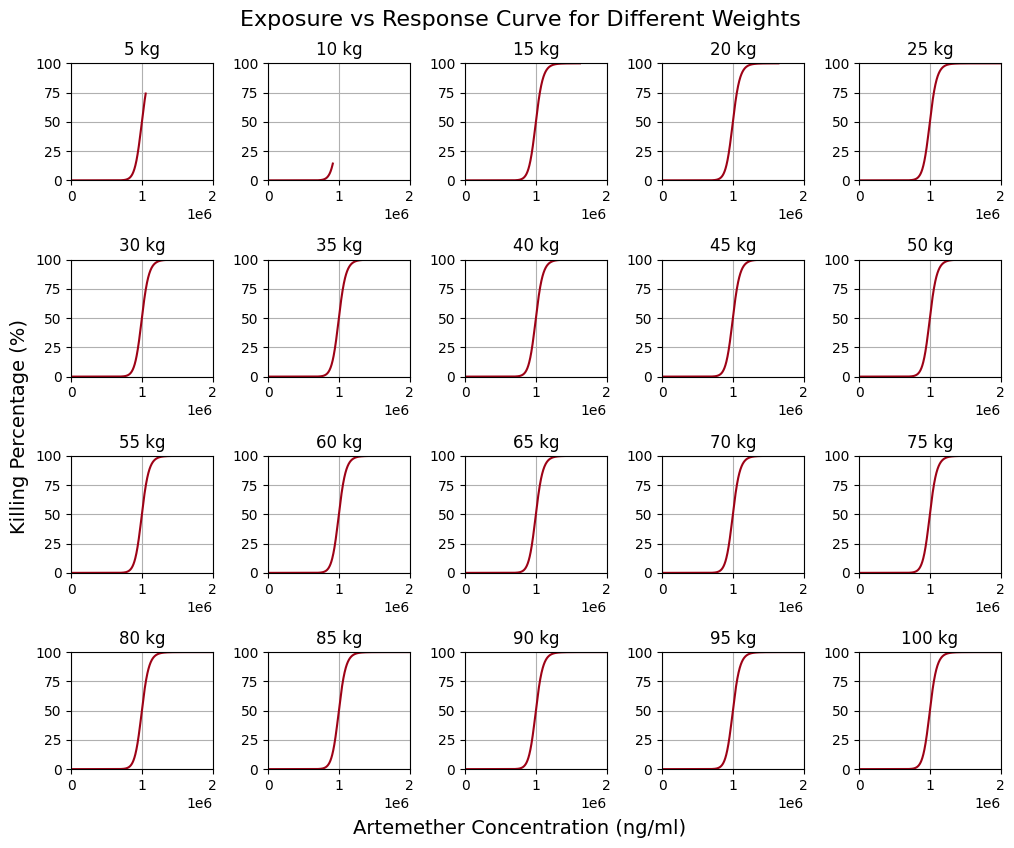

In [25]:
# Creating subplots for each weight for only killing percentage
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_ng_ml_final[i], kill_percent[i], label=f'Weight: {weight_values[i]} kg', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 2*10**6)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (ng/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different Weights', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

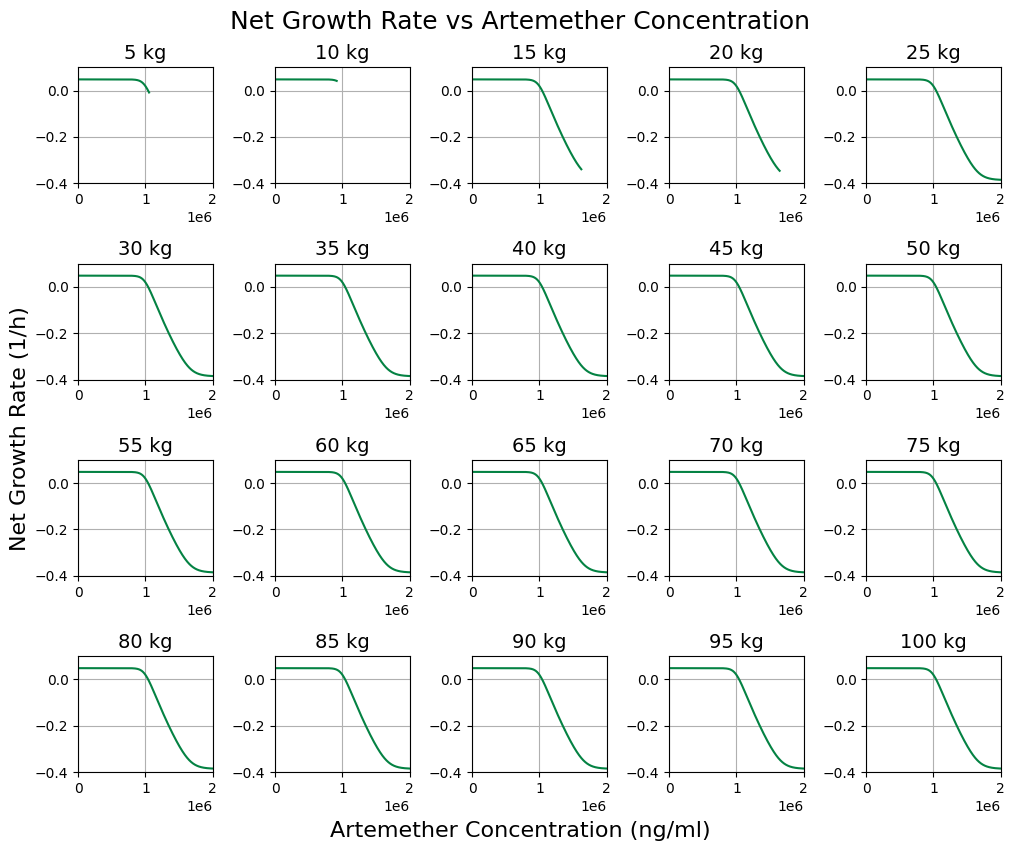

In [26]:
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_ng_ml_final[i], effect[i], label=f'Weight: {weight_values[i]} kg', color="#048243")
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 2*10**6)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (ng/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

In [27]:
kill_fraction = []
killing_rates = []

for i in range(0, len(artemether_concentrations_mg_ml_final)):
    temp_kill_fraction = []
    temp_killing_rates = []
    for concentration in artemether_concentrations_mg_ml_final[i]:
        temp_kill_fraction.append(sigmoid_function(concentration, pmax, ec50_concentrations_mg[i], n))
        temp_killing_rates.append((-1/24) * np.log(1.0 - temp_kill_fraction[-1]))
    kill_fraction.append(temp_kill_fraction)
    killing_rates.append(temp_killing_rates)

growth_rate = 0.048 
effect = [] 

for i in range(len(killing_rates)):
    effect.append(growth_rate - np.array(killing_rates[i]))

kill_percent = []
for i in range(len(kill_fraction)):
    temp_kill_percent = []
    for j in range(len(kill_fraction[i])):
        temp_kill_percent.append(kill_fraction[i][j] * 100)
    kill_percent.append(temp_kill_percent)

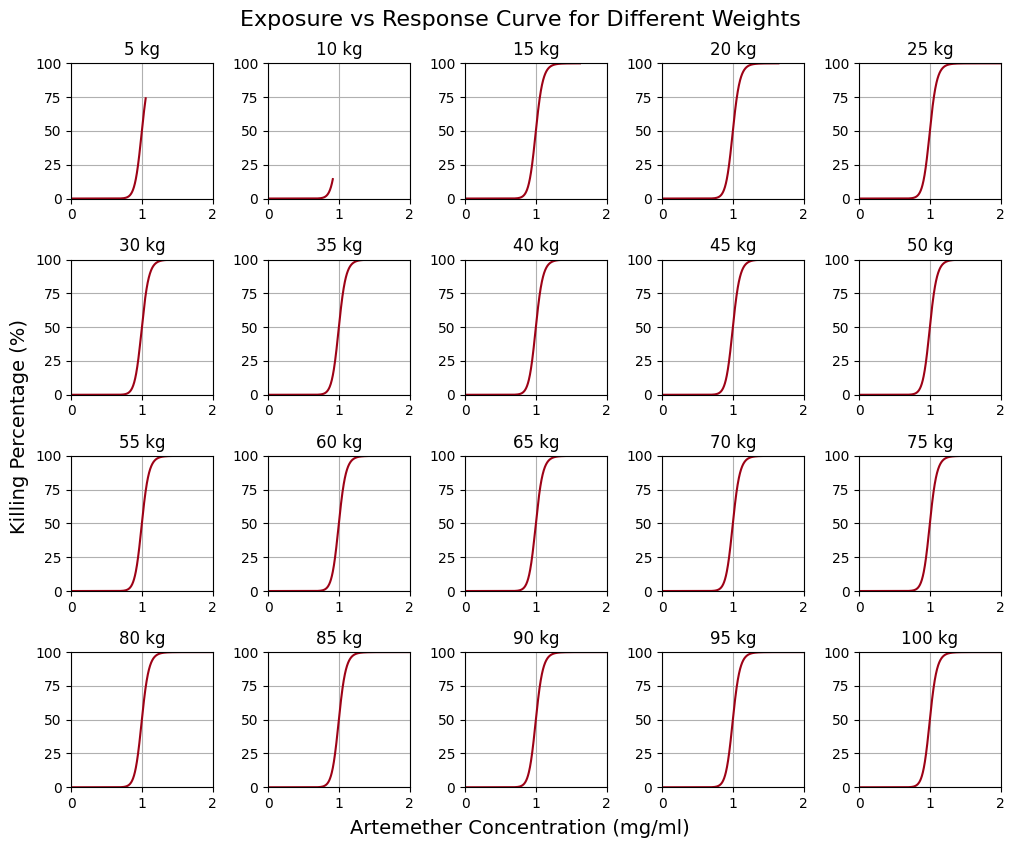

In [28]:
# Creating subplots for each weight for only killing percentage
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], kill_percent[i], label=f'Weight: {weight_values[i]} kg', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 2)  # Adjusted for mg/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different Weights', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

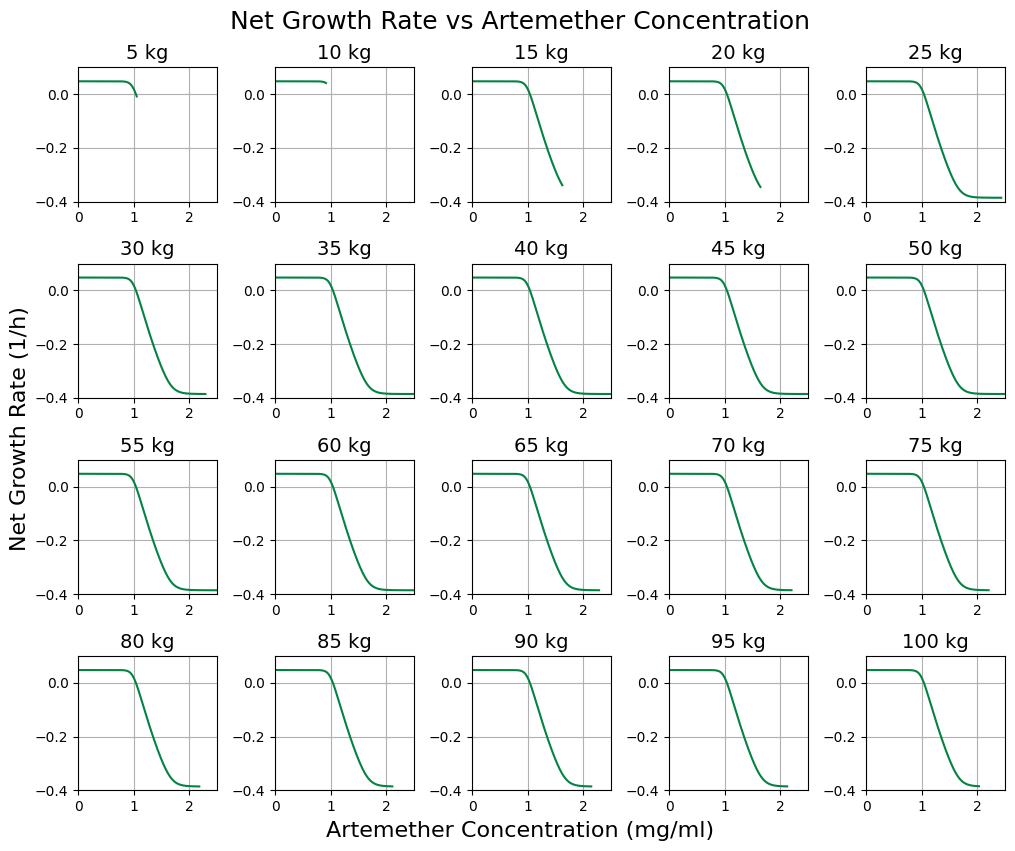

In [29]:
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], effect[i], label=f'Weight: {weight_values[i]} kg', color="#048243")
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 2.5)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

### 2. Using WHO dosing regimen and variable (not random but sequential) BMI within same weight groups

In [54]:
# Generating total dose for each weight over 3 days with twice daily dosing
#weight_values = list(range(5, 101, 5))  # Re-defining weight values for clarity
weight_values = [5]
total_dose_mg = []

for weight in weight_values:
    total_mg_dose = generate_recommended_dosing_schedule(weight) * 6  # Assuming 3 days of treatment
    total_dose_mg.append(total_mg_dose)
# for i in range(len(weight_values)):
#     print(f"Total dose for weight {weight_values[i]} kg: {total_dose_mg[i]} mg")

upper_limit_mg = total_dose_mg
lower_limit_mg = [0] * len(weight_values)

lower_limit_concentration = []
upper_limit_concentration = []

patient_BMI = np.arange(18.5, 25, 0.1)  

for i in range(len(patient_BMI)):
    BMI_to_use = patient_BMI[i].round(2)
    total_blood_volume = (weight_values[0] ** 0.25)* (70/np.sqrt((BMI_to_use)/22))
    print(f"Using BMI: {BMI_to_use} with TBV {total_blood_volume} for weight {weight_values[0]}")
    lower_limit_concentration.append(lower_limit_mg[0] / total_blood_volume)
    upper_limit_concentration.append(upper_limit_mg[0] / total_blood_volume)
    print(f"Concentration range: {lower_limit_concentration[0]}to {upper_limit_concentration[0]} mg/mL\n")
    

artemether_concentrations_mg_ml_final = []
for i in range(len(patient_BMI)):
    temp_conc = np.linspace(lower_limit_concentration[i], upper_limit_concentration[i], 1000)
    artemether_concentrations_mg_ml_final.append(temp_conc)

#Convert artemether_concentrations_ng_ml_final to artemether_concentrations_mg_ml_final
artemether_concentrations_ng_ml_final = []
for i in range(len(artemether_concentrations_mg_ml_final)):
    temp_conc = artemether_concentrations_mg_ml_final[i] * (10**6)  # Convert mg/mL to ng/mL
    artemether_concentrations_ng_ml_final.append(temp_conc)

pmax = 0.99997
ec50_dose_ng = 1*(10**6)  # Convert ng/mL to ng/mg
ec50_dose_mg = 1  
n = 20
ec50_concentrations_ng = [ec50_dose_ng for BMI in patient_BMI] # Assuming ec50 is already a concentration
ec50_concentrations_mg = [ec50_dose_mg for BMI in patient_BMI]  # Convert ng/mL to mg/mL

print("EC50 Concentrations (ng/mL):", ec50_concentrations_ng)
print("EC50 Concentrations (mg/mL):", ec50_concentrations_mg)

Using BMI: 18.5 with TBV 114.14739830219932 for weight 5
Concentration range: 0.0to 1.0512723179402321 mg/mL

Using BMI: 18.6 with TBV 113.84013691497985 for weight 5
Concentration range: 0.0to 1.0512723179402321 mg/mL

Using BMI: 18.7 with TBV 113.5353434981111 for weight 5
Concentration range: 0.0to 1.0512723179402321 mg/mL

Using BMI: 18.8 with TBV 113.23298518900147 for weight 5
Concentration range: 0.0to 1.0512723179402321 mg/mL

Using BMI: 18.9 with TBV 112.9330297344351 for weight 5
Concentration range: 0.0to 1.0512723179402321 mg/mL

Using BMI: 19.0 with TBV 112.6354454761203 for weight 5
Concentration range: 0.0to 1.0512723179402321 mg/mL

Using BMI: 19.1 with TBV 112.34020133665449 for weight 5
Concentration range: 0.0to 1.0512723179402321 mg/mL

Using BMI: 19.2 with TBV 112.04726680589175 for weight 5
Concentration range: 0.0to 1.0512723179402321 mg/mL

Using BMI: 19.3 with TBV 111.75661192769942 for weight 5
Concentration range: 0.0to 1.0512723179402321 mg/mL

Using BMI: 19

In [55]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(patient_BMI)):
    print(f"Total Concentration range for weight {weight_values[0]} kg with BMI {patient_BMI[i].round(2)} is: {artemether_concentrations_ng_ml_final[i][0]} ng/mL to {artemether_concentrations_ng_ml_final[i][-1]} ng/mL")

Total Concentration range for weight 5 kg with BMI 18.5 is: 0.0 ng/mL to 1051272.317940232 ng/mL
Total Concentration range for weight 5 kg with BMI 18.6 is: 0.0 ng/mL to 1054109.7652545918 ng/mL
Total Concentration range for weight 5 kg with BMI 18.7 is: 0.0 ng/mL to 1056939.5952194962 ng/mL
Total Concentration range for weight 5 kg with BMI 18.8 is: 0.0 ng/mL to 1059761.868855647 ng/mL
Total Concentration range for weight 5 kg with BMI 18.9 is: 0.0 ng/mL to 1062576.646373369 ng/mL
Total Concentration range for weight 5 kg with BMI 19.0 is: 0.0 ng/mL to 1065383.9871875949 ng/mL
Total Concentration range for weight 5 kg with BMI 19.1 is: 0.0 ng/mL to 1068183.9499325007 ng/mL
Total Concentration range for weight 5 kg with BMI 19.2 is: 0.0 ng/mL to 1070976.5924757933 ng/mL
Total Concentration range for weight 5 kg with BMI 19.3 is: 0.0 ng/mL to 1073761.9719326638 ng/mL
Total Concentration range for weight 5 kg with BMI 19.4 is: 0.0 ng/mL to 1076540.1446794192 ng/mL
Total Concentration ran

Text(0.5, 1.0, 'Artemether Concentration Distribution by BMI')

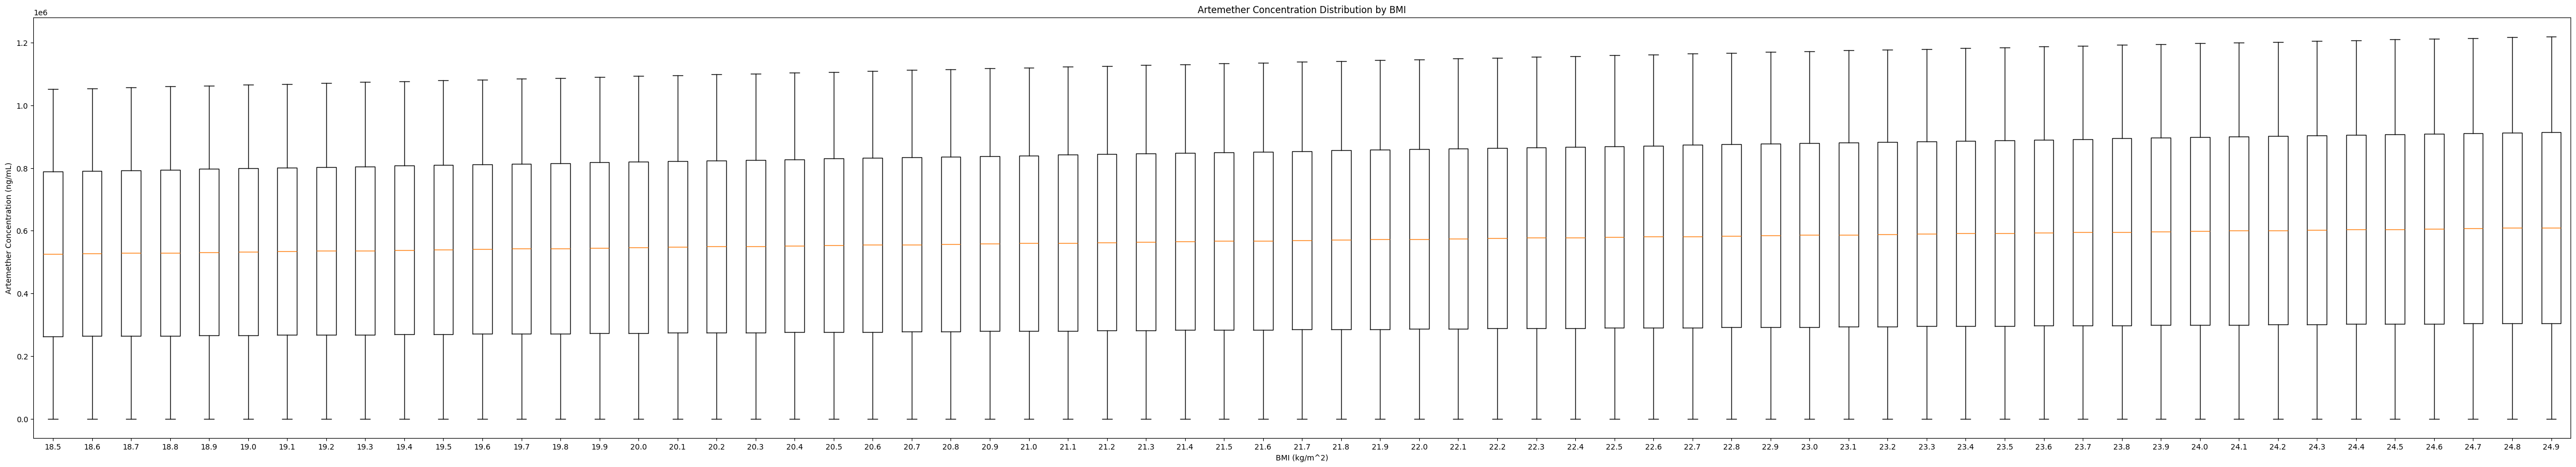

In [56]:
plt.figure(figsize=(60, 10))
plt.boxplot(artemether_concentrations_ng_ml_final, tick_labels=patient_BMI.round(2))
plt.xlabel('BMI (kg/m^2)')
plt.ylabel('Artemether Concentration (ng/mL)')
plt.title('Artemether Concentration Distribution by BMI')

In [57]:
kill_fraction = []
killing_rates = []

for i in range(0, len(artemether_concentrations_ng_ml_final)):
    temp_kill_fraction = []
    temp_killing_rates = []
    for concentration in artemether_concentrations_ng_ml_final[i]:
        temp_kill_fraction.append(sigmoid_function(concentration, pmax, ec50_concentrations_ng[i], n))
        temp_killing_rates.append((-1/24) * np.log(1.0 - temp_kill_fraction[-1]))
    kill_fraction.append(temp_kill_fraction)
    killing_rates.append(temp_killing_rates)

growth_rate = 0.048 
effect = [] 

for i in range(len(killing_rates)):
    effect.append(growth_rate - np.array(killing_rates[i]))

kill_percent = []
for i in range(len(kill_fraction)):
    temp_kill_percent = []
    for j in range(len(kill_fraction[i])):
        temp_kill_percent.append(kill_fraction[i][j] * 100)
    kill_percent.append(temp_kill_percent)

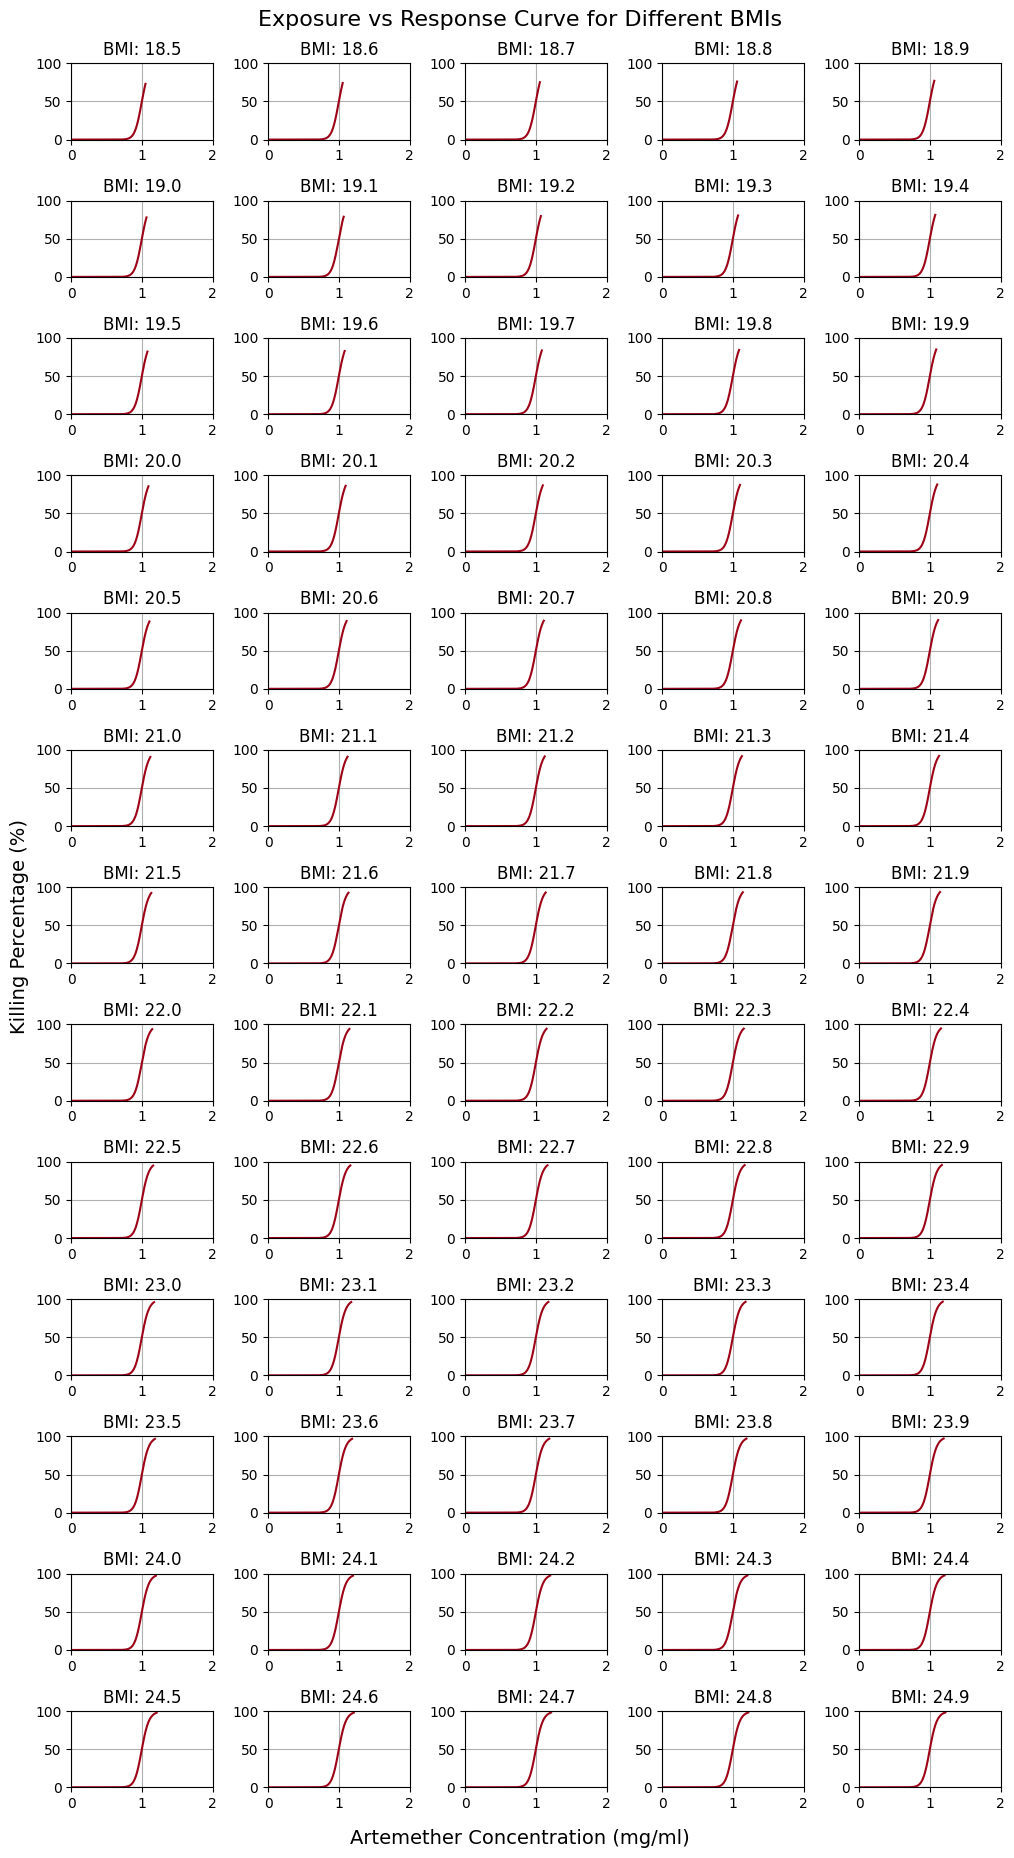

In [66]:
# Creating subplots for each BMI for only killing percentage
fig, axs = plt.subplots(13, 5, figsize=(10, 18))
for i in range(len(patient_BMI)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], kill_percent[i], label=f'BMI: {patient_BMI[i].round(2)} kg/m^2', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 2)  # Adjusted for mg/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'BMI: {patient_BMI[i].round(2)}', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different BMIs', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

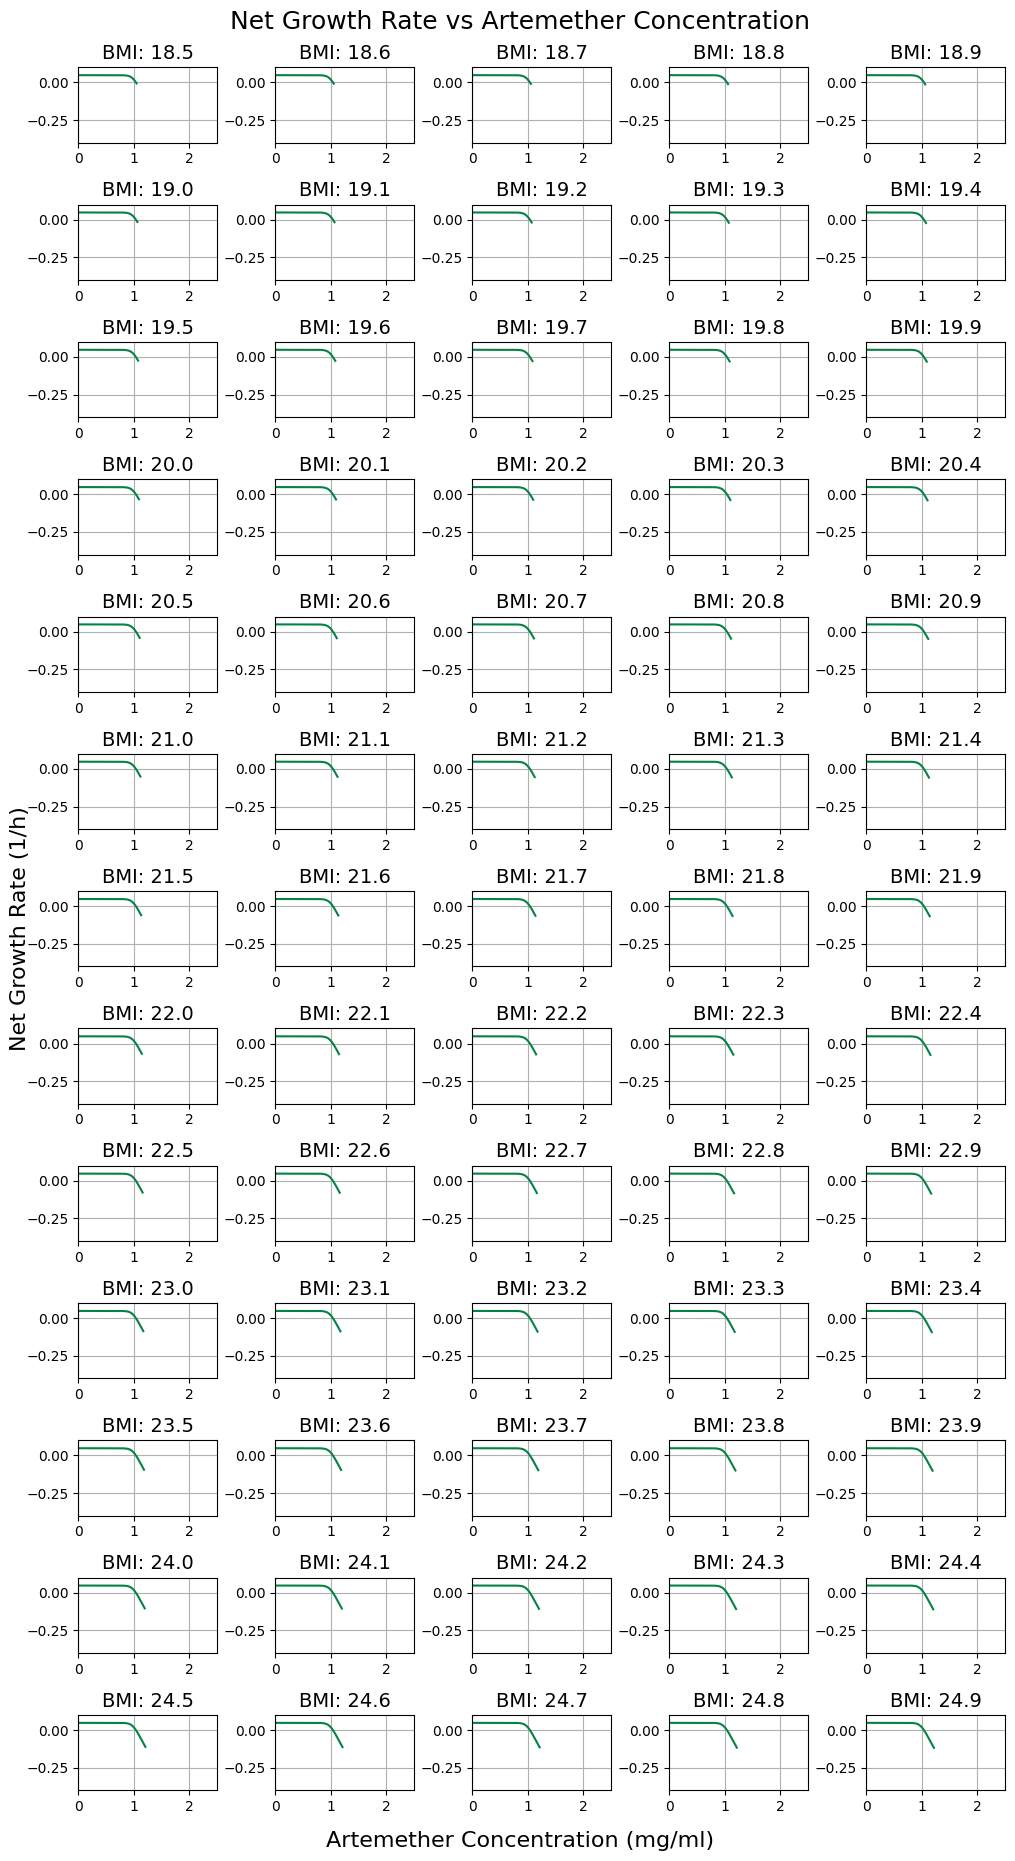

In [70]:
fig, axs = plt.subplots(13, 5, figsize=(10, 18))
for i in range(len(patient_BMI)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], effect[i], label=f'BMI: {patient_BMI[i].round(2)} kg/m^2', color="#048243")
    axs[i // 5, i % 5].set_title(f'BMI: {patient_BMI[i].round(2)}', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 2.5)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

#### Looks like scaling using a higher BMI may help lower weights, repeating analysis with 10 Kg

In [71]:
# Generating total dose for each weight over 3 days with twice daily dosing
#weight_values = list(range(5, 101, 5))  # Re-defining weight values for clarity
weight_values = [10]
total_dose_mg = []

for weight in weight_values:
    total_mg_dose = generate_recommended_dosing_schedule(weight) * 6  # Assuming 3 days of treatment
    total_dose_mg.append(total_mg_dose)
# for i in range(len(weight_values)):
#     print(f"Total dose for weight {weight_values[i]} kg: {total_dose_mg[i]} mg")

upper_limit_mg = total_dose_mg
lower_limit_mg = [0] * len(weight_values)

lower_limit_concentration = []
upper_limit_concentration = []

patient_BMI = np.arange(18.5, 25, 0.1)  

for i in range(len(patient_BMI)):
    BMI_to_use = patient_BMI[i].round(2)
    total_blood_volume = (weight_values[0] ** 0.25)* (70/np.sqrt((BMI_to_use)/22))
    print(f"Using BMI: {BMI_to_use} with TBV {total_blood_volume} for weight {weight_values[0]}")
    lower_limit_concentration.append(lower_limit_mg[0] / total_blood_volume)
    upper_limit_concentration.append(upper_limit_mg[0] / total_blood_volume)
    print(f"Concentration range: {lower_limit_concentration[0]}to {upper_limit_concentration[0]} mg/mL\n")
    

artemether_concentrations_mg_ml_final = []
for i in range(len(patient_BMI)):
    temp_conc = np.linspace(lower_limit_concentration[i], upper_limit_concentration[i], 1000)
    artemether_concentrations_mg_ml_final.append(temp_conc)

#Convert artemether_concentrations_ng_ml_final to artemether_concentrations_mg_ml_final
artemether_concentrations_ng_ml_final = []
for i in range(len(artemether_concentrations_mg_ml_final)):
    temp_conc = artemether_concentrations_mg_ml_final[i] * (10**6)  # Convert mg/mL to ng/mL
    artemether_concentrations_ng_ml_final.append(temp_conc)

pmax = 0.99997
ec50_dose_ng = 1*(10**6)  # Convert ng/mL to ng/mg
ec50_dose_mg = 1  
n = 20
ec50_concentrations_ng = [ec50_dose_ng for BMI in patient_BMI] # Assuming ec50 is already a concentration
ec50_concentrations_mg = [ec50_dose_mg for BMI in patient_BMI]  # Convert ng/mL to mg/mL

print("EC50 Concentrations (ng/mL):", ec50_concentrations_ng)
print("EC50 Concentrations (mg/mL):", ec50_concentrations_mg)

Using BMI: 18.5 with TBV 135.74489822002496 for weight 10
Concentration range: 0.0to 0.8840111236114044 mg/mL

Using BMI: 18.6 with TBV 135.37950079217796 for weight 10
Concentration range: 0.0to 0.8840111236114044 mg/mL

Using BMI: 18.7 with TBV 135.01703829223163 for weight 10
Concentration range: 0.0to 0.8840111236114044 mg/mL

Using BMI: 18.8 with TBV 134.65747163975828 for weight 10
Concentration range: 0.0to 0.8840111236114044 mg/mL

Using BMI: 18.9 with TBV 134.30076247900408 for weight 10
Concentration range: 0.0to 0.8840111236114044 mg/mL

Using BMI: 19.0 with TBV 133.9468731617033 for weight 10
Concentration range: 0.0to 0.8840111236114044 mg/mL

Using BMI: 19.1 with TBV 133.5957667303877 for weight 10
Concentration range: 0.0to 0.8840111236114044 mg/mL

Using BMI: 19.2 with TBV 133.2474069021747 for weight 10
Concentration range: 0.0to 0.8840111236114044 mg/mL

Using BMI: 19.3 with TBV 132.9017580530181 for weight 10
Concentration range: 0.0to 0.8840111236114044 mg/mL

Using

In [74]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(patient_BMI)):
    print(f"Total Concentration range for weight {weight_values[0]} kg with BMI {patient_BMI[i].round(2)} is: {artemether_concentrations_ng_ml_final[i][0]} ng/mL to {artemether_concentrations_ng_ml_final[i][-1]} ng/mL")

Total Concentration range for weight 10 kg with BMI 18.5 is: 0.0 ng/mL to 884011.1236114044 ng/mL
Total Concentration range for weight 10 kg with BMI 18.6 is: 0.0 ng/mL to 886397.1228865207 ng/mL
Total Concentration range for weight 10 kg with BMI 18.7 is: 0.0 ng/mL to 888776.7167597865 ng/mL
Total Concentration range for weight 10 kg with BMI 18.8 is: 0.0 ng/mL to 891149.9565432908 ng/mL
Total Concentration range for weight 10 kg with BMI 18.9 is: 0.0 ng/mL to 893516.8928676798 ng/mL
Total Concentration range for weight 10 kg with BMI 19.0 is: 0.0 ng/mL to 895877.575694758 ng/mL
Total Concentration range for weight 10 kg with BMI 19.1 is: 0.0 ng/mL to 898232.0543297932 ng/mL
Total Concentration range for weight 10 kg with BMI 19.2 is: 0.0 ng/mL to 900580.3774335327 ng/mL
Total Concentration range for weight 10 kg with BMI 19.3 is: 0.0 ng/mL to 902922.5930339367 ng/mL
Total Concentration range for weight 10 kg with BMI 19.4 is: 0.0 ng/mL to 905258.7485376388 ng/mL
Total Concentration r

Text(0.5, 1.0, 'Artemether Concentration Distribution by BMI')

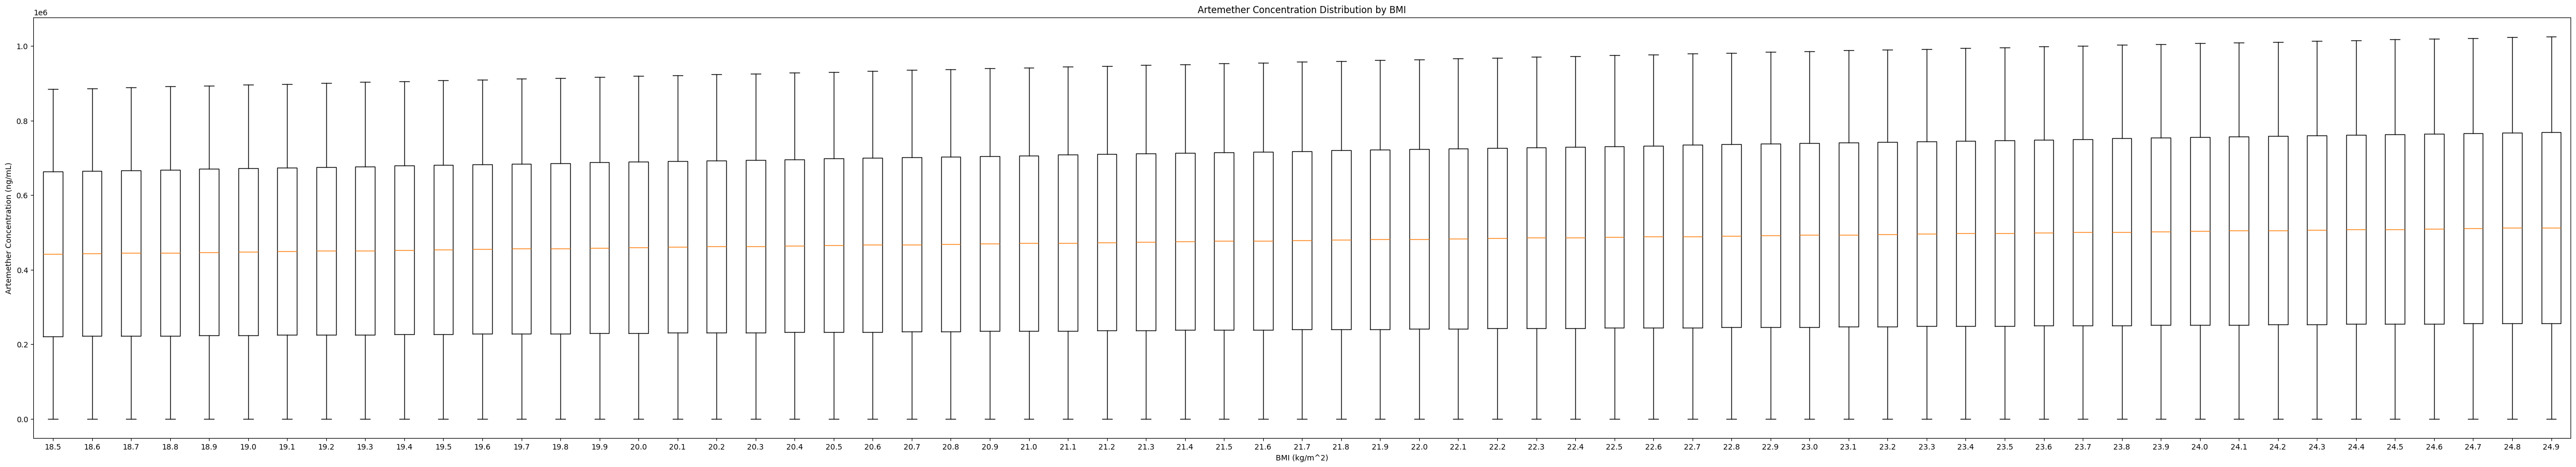

In [75]:
plt.figure(figsize=(60, 10))
plt.boxplot(artemether_concentrations_ng_ml_final, tick_labels=patient_BMI.round(2))
plt.xlabel('BMI (kg/m^2)')
plt.ylabel('Artemether Concentration (ng/mL)')
plt.title('Artemether Concentration Distribution by BMI')

In [76]:
kill_fraction = []
killing_rates = []

for i in range(0, len(artemether_concentrations_ng_ml_final)):
    temp_kill_fraction = []
    temp_killing_rates = []
    for concentration in artemether_concentrations_ng_ml_final[i]:
        temp_kill_fraction.append(sigmoid_function(concentration, pmax, ec50_concentrations_ng[i], n))
        temp_killing_rates.append((-1/24) * np.log(1.0 - temp_kill_fraction[-1]))
    kill_fraction.append(temp_kill_fraction)
    killing_rates.append(temp_killing_rates)

growth_rate = 0.048 
effect = [] 

for i in range(len(killing_rates)):
    effect.append(growth_rate - np.array(killing_rates[i]))

kill_percent = []
for i in range(len(kill_fraction)):
    temp_kill_percent = []
    for j in range(len(kill_fraction[i])):
        temp_kill_percent.append(kill_fraction[i][j] * 100)
    kill_percent.append(temp_kill_percent)

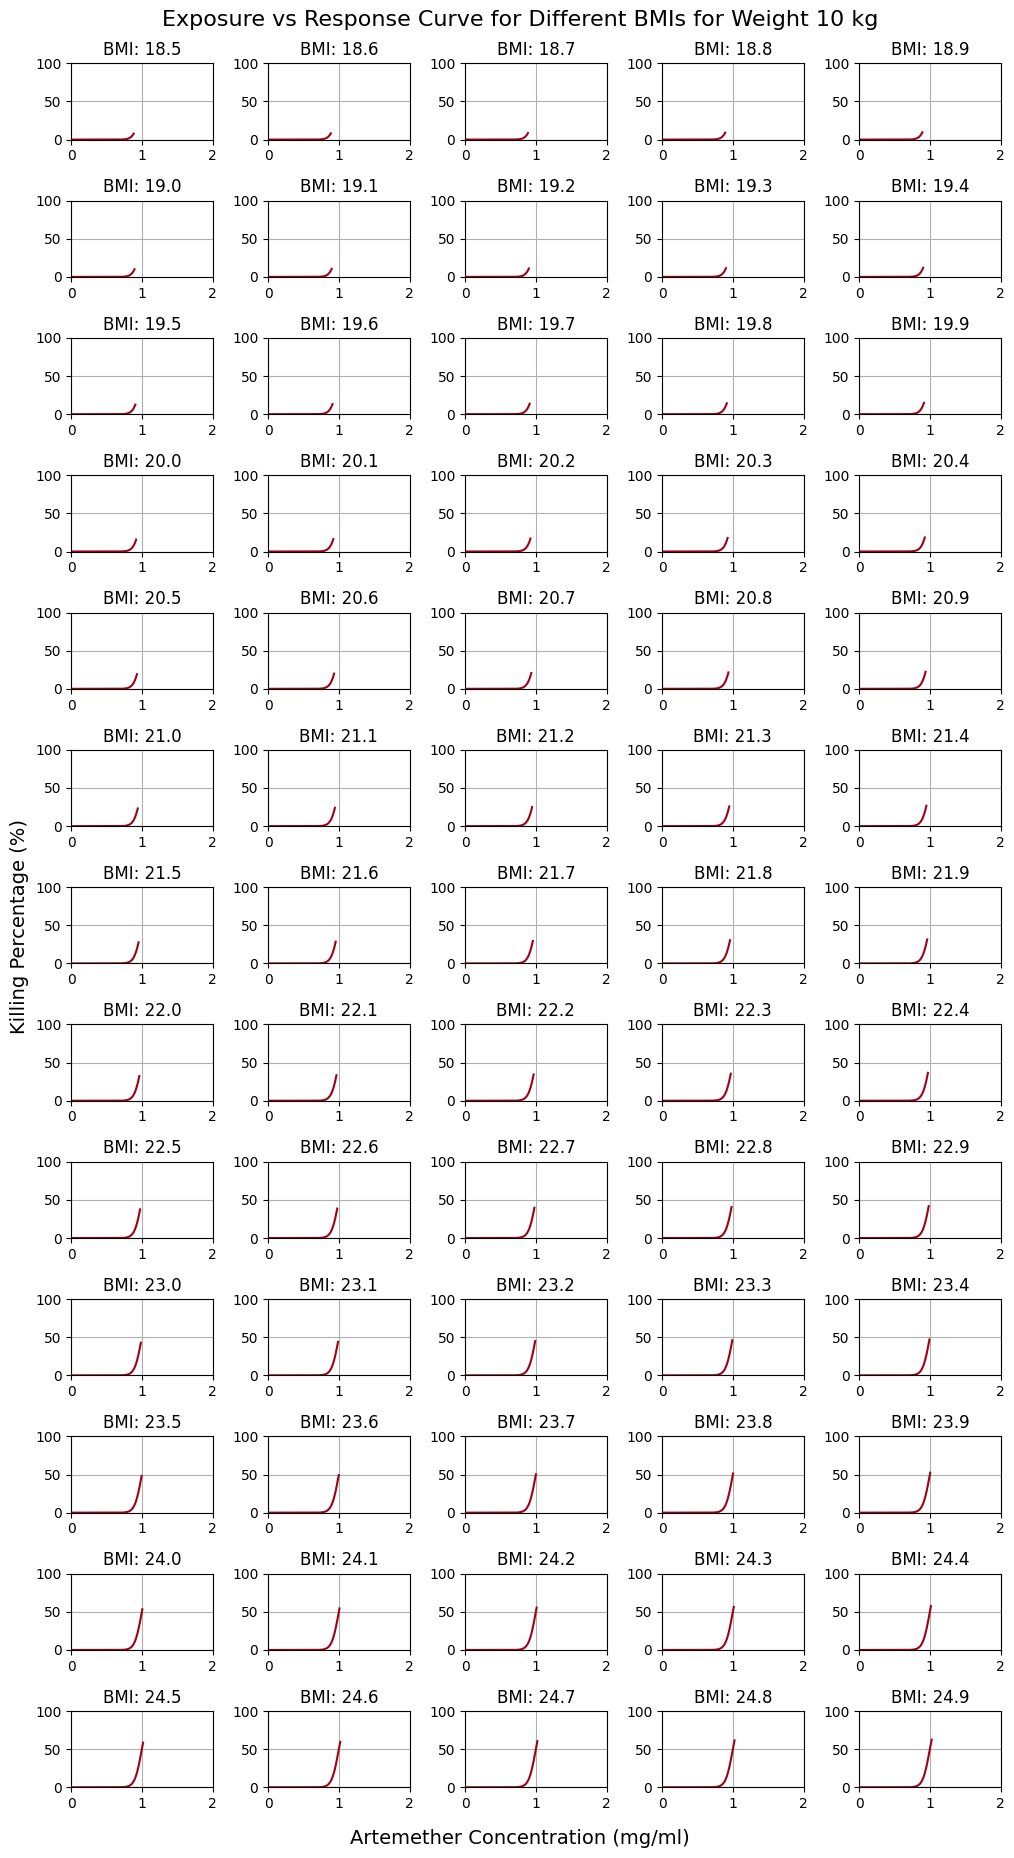

In [77]:
# Creating subplots for each BMI for only killing percentage
fig, axs = plt.subplots(13, 5, figsize=(10, 18))
for i in range(len(patient_BMI)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], kill_percent[i], label=f'BMI: {patient_BMI[i].round(2)} kg/m^2', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 2)  # Adjusted for mg/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'BMI: {patient_BMI[i].round(2)}', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different BMIs for Weight 10 kg', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

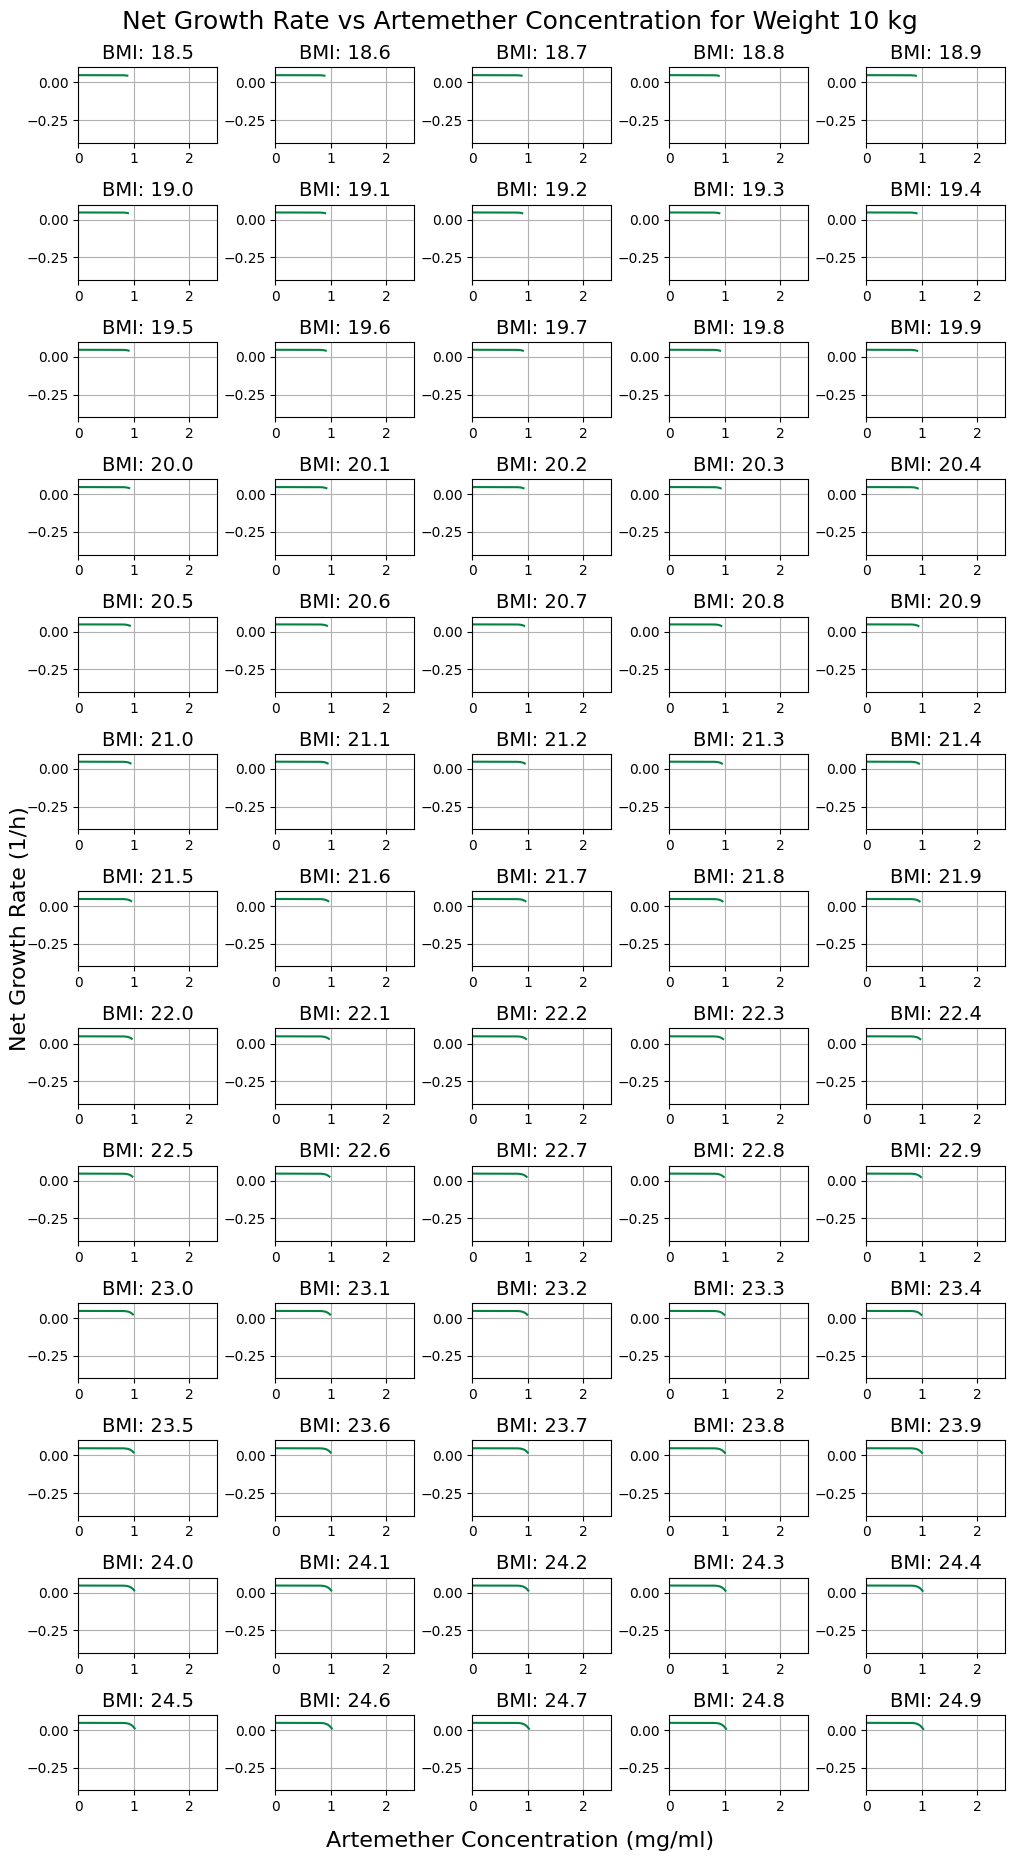

In [78]:
fig, axs = plt.subplots(13, 5, figsize=(10, 18))
for i in range(len(patient_BMI)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], effect[i], label=f'BMI: {patient_BMI[i].round(2)} kg/m^2', color="#048243")
    axs[i // 5, i % 5].set_title(f'BMI: {patient_BMI[i].round(2)}', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 2.5)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration for Weight 10 kg', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

#### Seems like a higher BMI helps weights > 5 Kg but not 5 to > 10 Kg (too little drug, higher body mass)